## Load the data

In [1]:
############## create sql table ################
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'stack_exchange_rnn_db'
q_tbname = 'question_table'
a_tbname = 'answer_table'
username = 'dan-laptop'
import os
password = os.environ['PGRES_PASSWORD']

engine = create_engine('postgresql://%s:%s@localhost:5432/%s'%(username,password,dbname))

## Now access sql db from python
con = None
connect_str = "dbname='%s' user='%s' host='localhost' password='%s'"%(dbname,username,password)
con = psycopg2.connect(connect_str)
cur = con.cursor() #create cursor for communicating with sql

almost 88k questions which is a little over 1/2 the python questions asked in 2015...

In [3]:
import pandas as pd
################# make query ########################
sql_query = 'SELECT q_id, view_count,score FROM question_table;'
question_df = pd.read_sql_query(sql_query,con)
question_df.head()

q_id  view_count  score
0  33660178          94      0
1  29972894        2859      0
2  32276493        8166     11
3  32586454        2936     -2
4  28136104        3748      4

In [4]:
sql_query = 'SELECT * FROM question_table;'
question_df = pd.read_sql_query(sql_query,con)
question_df.to_csv('question_db.csv')

sql_query = 'SELECT * FROM answer_table;'
question_df = pd.read_sql_query(sql_query,con)
question_df.to_csv('answer_db.csv')

In [5]:
question_df.head()

id  a_id      q_id                                           word_vec  \
0   1     0  33660178  the,error,object,may,read,from,the,network,net...   
1   2     1  33660178  this,is,what,i,did,worked,for,me,when,reading,...   
2   3     0  29972894  possible,duplicate,stackoverflow,com,questions...   
3   4     1  29972894  you,are,looking,for,idxmax,in,1332,x,out,1332,...   
4   5     2  29972894  x,max,x,max,x,max,axis,1,max,index,this,works,...   

   score  
0      0  
1      0  
2      0  
3      2  
4      0

In [4]:
len(question_df)

138286

In [5]:
print(len(question_df.view_count))

138286


In [6]:
print(question_df.view_count.max())

433072


In [7]:
print(question_df.view_count.min())

5


In [8]:
print(sum(question_df.view_count>100))

75058


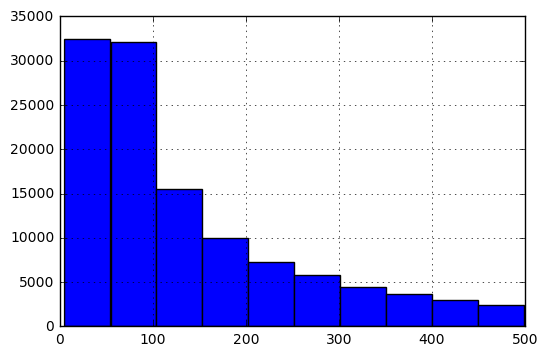

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

question_df[question_df['view_count']<500]['view_count'].hist();

In [10]:
import numpy as np
np.sum(question_df['view_count']<51)/len(question_df['view_count'])

0.20320205949987707

In [11]:
################# make query ########################
sql_query = 'SELECT word_vec,score FROM answer_table;'
question_df = pd.read_sql_query(sql_query,con)
print(question_df.shape)

(499225, 2)


In [12]:
################# make query ########################
sql_query = """
    SELECT answer_table.word_vec, answer_table.score 
    FROM answer_table
    INNER JOIN question_table
        on answer_table.q_id = question_table.q_id
        and question_table.view_count > 50;
"""
question_df = pd.read_sql_query(sql_query,con)
print(question_df.shape)
question_df.head()

(411190, 2)


word_vec  score
0  you,need,to,define,a,badge,model,as,well,and,d...      3
1  you,can,read,a,large,file,one,line,at,a,time,i...      1
2  this,would,be,eaily,accomplised,with,something...      0
3  in,my,opinion,the,easiest,way,would,be,to,use,...      1
4  biopython,should,be,able,to,read,in,large,fast...      0

In [ ]:
from nltk.tokenize import PunktSentenceTokenizer
question_df['word_vec'].values

custom_sent_tokenizer = PunktSentenceTokenizer(train_text) #A
tokenized = custom_sent_tokenizer.tokenize(sample_text)   #B

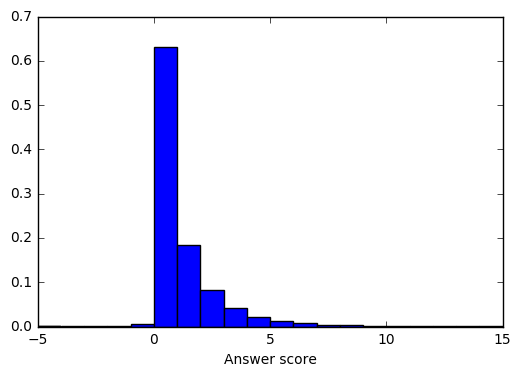

In [16]:
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#sns.set_context("poster")
plt.Figure()
#sns.distplot(question_df['score'],bins=20,kde=False, hist_kws={"range":(-5,15)}, norm_hist=True)
plt.hist(question_df['score'],bins=20,range=(-5,15), normed=True,color='b')
plt.xlim((-5,15))
plt.xlabel('Answer score')
#plt.savefig('answer_scores.png')
#plt.savefig('answer_scores.svg')
plt.show()

In [22]:
np.sum(question_df['score']==2)

33665

In [37]:
question_df.to_csv('answers_50more_views.csv')

In [47]:
len(question_df)

410757

In [48]:
import numpy as np
threshold = 2

y = question_df['score'].copy()
y[y<threshold] = 0
y[y>0] = 1
print(np.mean(y))

0.1797169616099056


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split

In [6]:
from sklearn.externals import joblib

lg = joblib.load('../Data_and_Models/lin_reg_model.pkl')
vectorizer = joblib.load('../Data_and_Models/count_vec.pkl')
tf_transformer = joblib.load('../Data_and_Models/tfidf_tansformer.pkl')

In [5]:
vectorizer = CountVectorizer(lowercase=False,ngram_range=(1,2))
X_count = vectorizer.fit_transform(question_df['word_vec'].values)

tf_transformer = TfidfTransformer()
X_tf = tf_transformer.fit_transform(X_count)

X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.1)

In [24]:
lg = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,n_iter=1,verbose=0,class_weight='balanced')

from time import time

t0 = time()
epochs=5
for i in range(epochs):
    lg.fit(X_train,y_train)
    if (i+1)%1==0: print('Epoch %s. Cross Validated Acc:%0.2f'%(i+1,lg.score(X_test,y_test)))

print("done in %0.3fs." % (time() - t0))

Epoch 1. Cross Validated Acc:0.79
Epoch 2. Cross Validated Acc:0.78
Epoch 3. Cross Validated Acc:0.78
Epoch 4. Cross Validated Acc:0.79
Epoch 5. Cross Validated Acc:0.78
done in 2.067s.


In [6]:
from sklearn.externals import joblib

lg = joblib.load('lin_reg_model.pkl') 
vectorizer = joblib.load('count_vec.pkl')
tf_transformer = joblib.load('tfidf_tansformer.pkl')

In [7]:
X_count = vectorizer.transform(question_df['word_vec'].values)
X_tf = tf_transformer.transform(X_count)

X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.1)

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#%matplotlib inline

def create_ROC_plt(lg,X_test,y_test,lw=2):
    y_score = lg.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',\
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

In [9]:
create_ROC_plt(lg,X_test,y_test)

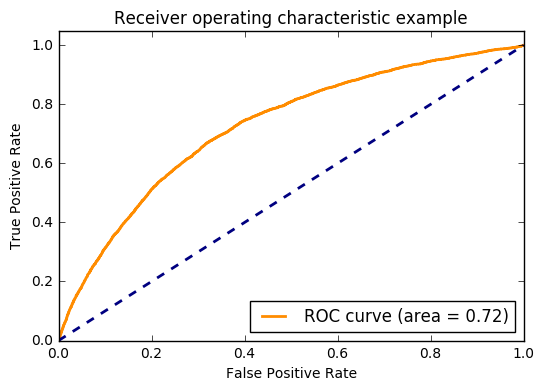

In [10]:
plt.show()

In [13]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

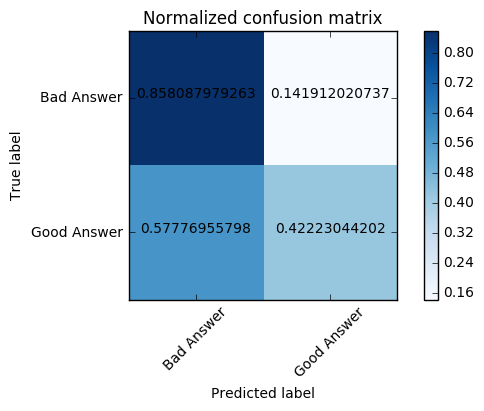

In [14]:
y_pred = lg.predict(X_test)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'], normalize=True,\
                      title='Normalized confusion matrix')

In [34]:
from sklearn.externals import joblib
joblib.dump(lg, 'lin_reg_model.pkl') 
#lg = joblib.load('lin_reg_model.pkl') 

['lin_reg_model.pkl',
 'lin_reg_model.pkl_01.npy',
 'lin_reg_model.pkl_02.npy',
 'lin_reg_model.pkl_03.npy',
 'lin_reg_model.pkl_04.npy']

In [12]:
joblib.dump(vectorizer,'count_vec.pkl')
joblib.dump(tf_transformer,'tfidf_tansformer.pkl')

['tfidf_tansformer.pkl',
 'tfidf_tansformer.pkl_01.npy',
 'tfidf_tansformer.pkl_02.npy']

In [29]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()

nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

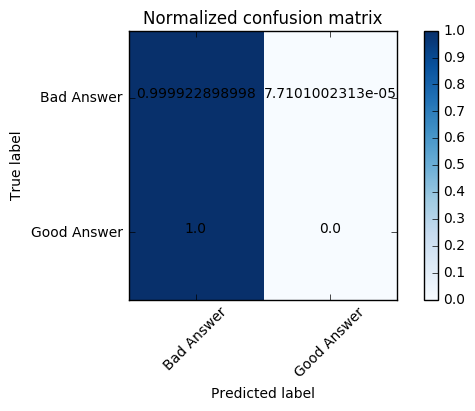

In [33]:
y_pred = nb.predict(X_test)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'], normalize=True,\
                      title='Normalized confusion matrix')

## Below is the grid search i did to find the values above

In [188]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(question_df['word_vec'].values, y, test_size=0.1)

In [189]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([('vect', CountVectorizer(lowercase=False)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, class_weight='balanced')),
                     ])

if this model continues to work look at the best parameters, recreate it outside the pipeline, save it, and see if you can train it further with more gradient descent. Also see how well a naive bayes can do. 

If all this works, then do your resume, edit the plots from last time, and make presentation. Don't use plot 3. Just report the percent of good answers. Remake the final plot but as views against answer score to show why this is better as a classification problem.

After all this, get started on that webapp!!!

In [190]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
             }

from sklearn.grid_search import GridSearchCV

t0 = time()
rs_clf = GridSearchCV(text_clf, parameters, n_jobs=1)
rs_clf.fit(X_train, y_train)
print("done in %0.3fs." % (time() - t0))

done in 1227.262s.


In [191]:
rs_clf.best_score_

0.77050544121672793

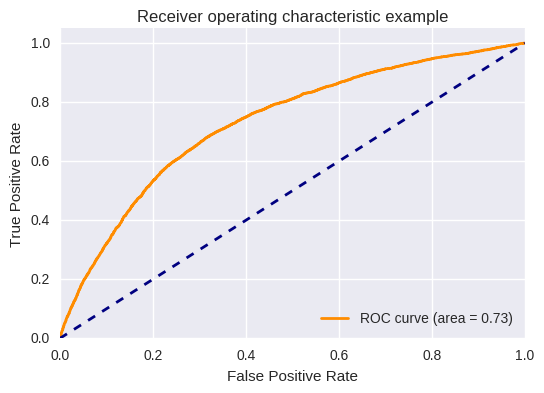

In [195]:
create_ROC_plt(rs_clf,X_test,y_test)

In [197]:
y_pred = rs_clf.predict(X_test)

In [200]:
print(rs_clf.score(X_test,y_test))

0.777148524989


Confusion matrix, without normalization
[[21889  3953]
 [ 3012  2400]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.56  0.44]]


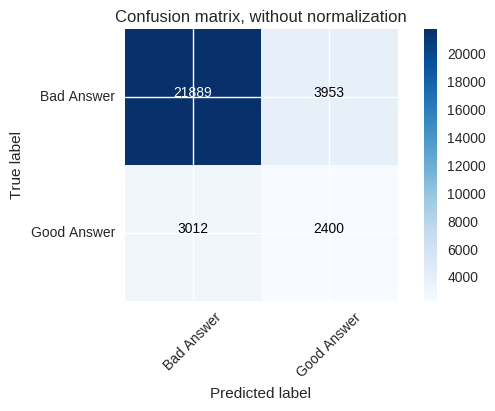

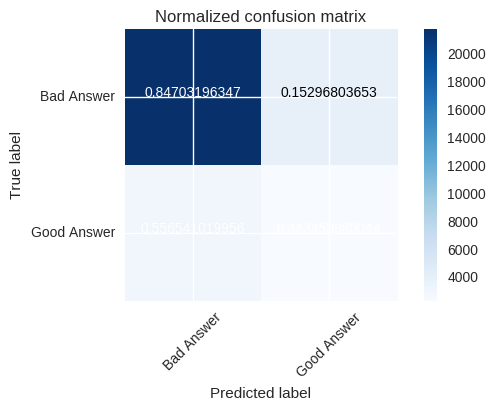

In [201]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'],\
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'], normalize=True,\
                      title='Normalized confusion matrix')

In [202]:
rs_clf.best_params_

{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [ ]:
########## Close Connections ##############
cur.close()
con.close()